In [1]:
from piq import ssim, psnr
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import cv2
import numpy as np
from PIL import Image, ImageDraw
from torchvision.datasets import ImageFolder

# Reconstruction Metric Statistics

In [2]:
# Generate a circular Region-of-Interest Mask with diameter 320.
mask = Image.new('L', (320,320),0)
draw = ImageDraw.Draw(mask)
draw.pieslice([0,0,320,320],0,360,fill=255)
toTensor = transforms.ToTensor()
mask = toTensor(mask)[0]

In [3]:
# UTIL: Dataset Loader
class DoubleImageFolder(ImageFolder):

    def __init__(self, roots, transform=None):
        super(DoubleImageFolder, self).__init__(root=roots[0])
        self.samples_0 = self.samples
        
        super(DoubleImageFolder, self).__init__(root=roots[1])
        self.samples_1 = self.samples
        
        self.transform = transform
        
        
    def __getitem__(self, index):
        path_0, target_0 = self.samples_0[index]
        path_1, target_1 = self.samples_1[index]
        
        sample_0 = self.loader(path_0)
        sample_1 = self.loader(path_1)
        if self.transform is not None:
            sample_0 = self.transform(sample_0)
        if self.target_transform is not None:
            target_0 = self.target_transform(target_0)
        if self.transform is not None:
            sample_1 = self.transform(sample_1)
        if self.target_transform is not None:
            target_1 = self.target_transform(target_1)

        return sample_0, sample_1

In [4]:
def get_box_data(prediction_dir, target_dir):
    # read data to range 0~1
    dataset = DoubleImageFolder(roots=[prediction_dir, target_dir],
                                transform=transforms.Compose([
                                    transforms.Grayscale(),
                                    transforms.ToTensor(),
                                ]))
#     print(dataset.class_to_idx)
    
    ssim_index = []
    psnr_result = []
    for class_name in dataset.class_to_idx.keys():
        class_idx = dataset.class_to_idx[class_name]
#         print(class_name,class_idx)
        targets = torch.tensor(dataset.targets)
        target_idx = np.nonzero(targets == class_idx)
#         print(len(target_idx))

        sampler = torch.utils.data.SubsetRandomSampler(target_idx)
        loader = torch.utils.data.DataLoader(dataset, sampler=sampler, batch_size=1)
    
        for i,data in enumerate(loader):
#             if i >= 33:
#                 break
            
            predictions, targets = data
            
            # Histogram-Peak-based Normalize
            pred_hist = torch.histc(predictions, bins=255)
            targ_hist = torch.histc(targets, bins=255)

            peak_pred1 = torch.argmax(pred_hist[:75])/255.
            peak_pred2 = (torch.argmax(pred_hist[75:])+75)/255.
            peak_targ1 = torch.argmax(targ_hist[:75])/255.
            peak_targ2 = (torch.argmax(targ_hist[75:])+75)/255.

            predictions = torch.clamp((predictions - peak_pred1)/(peak_pred2 - peak_pred1), min=0)
            targets = torch.clamp((targets - peak_targ1)/(peak_targ2 - peak_targ1), min=0)

            predictions = torch.clamp(predictions, max=torch.max(targets), min=0)
            predictions /= torch.max(targets)
            targets /= torch.max(targets)
            
            # Mask Region of Interest
            predictions = predictions * mask
            targets = targets * mask
            ssim_index.append(ssim(predictions, targets, data_range=1.))
            psnr_result.append(psnr(predictions, targets, data_range=1.))
    print(f'psnr: {sum(psnr_result)/len(psnr_result):.2f}, std: {np.std(psnr_result):.3f}, ssim: {sum(ssim_index)/len(ssim_index):.3f}, std: {np.std(ssim_index):.3f}')
    return np.array(ssim_index), np.array(psnr_result)

In [5]:
# Adjust the folder path to your need.
tv_prediction_dir = 'Toy-Dataset/Fista'  # Fista-TV
cgan_prediction_dir = 'Toy-Dataset/CGAN'  # conditional GAN
nn_prediction_dir = 'Toy-Dataset/Neumann'  # Neumann Network
our_prediction_dir = 'Toy-Dataset/SIN-4c-PRN'  # Ours
target_dir = 'Toy-Dataset/Ground_Truth_reconstruction'

In [6]:
print('Order: FISTA-TV, cGAN, NN, Ours')
ssim1, psnr1 = get_box_data(tv_prediction_dir, target_dir)
ssim2, psnr2 = get_box_data(cgan_prediction_dir, target_dir)
ssim3, psnr3 = get_box_data(nn_prediction_dir, target_dir)
ssim4, psnr4 = get_box_data(our_prediction_dir, target_dir)

Order: FISTA-TV, cGAN, NN, Ours
psnr: 31.46, std: 3.034, ssim: 0.860, std: 0.044
psnr: 31.32, std: 1.721, ssim: 0.779, std: 0.044
psnr: 29.49, std: 1.502, ssim: 0.735, std: 0.075
psnr: 35.92, std: 1.862, ssim: 0.903, std: 0.029


{'whiskers': [<matplotlib.lines.Line2D at 0x7fba7c455810>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba7c4620d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba7c4553d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fba7c462990>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fba7c462dd0>,
 'means': []}

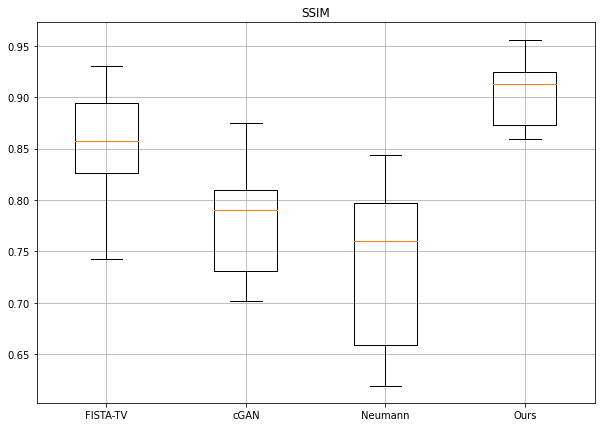

In [7]:
# BOX Plots
plt.figure(figsize=(10,7))
plt.title('SSIM')
plt.grid()
plt.boxplot([ssim1, ssim2, ssim3, ssim4], labels=['FISTA-TV', 'cGAN', 'Neumann', 'Ours'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba7c34fad0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba7c34ff10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba7c34f910>,
 'medians': [<matplotlib.lines.Line2D at 0x7fba7c3567d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fba7c356c10>,
 'means': []}

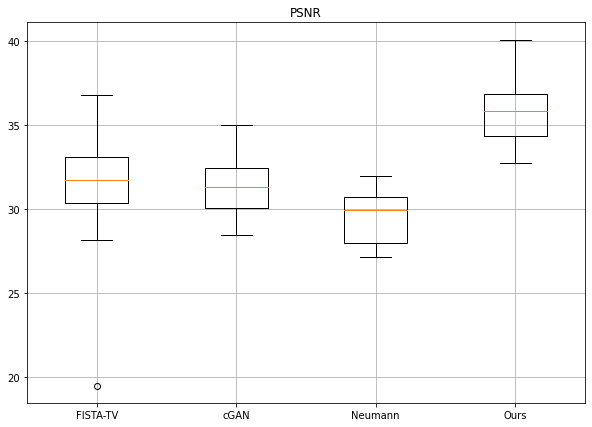

In [8]:
# BOX Plots
plt.figure(figsize=(10,7))
plt.title('PSNR')
plt.grid()
plt.boxplot([psnr1, psnr2, psnr3, psnr4], labels=['FISTA-TV', 'cGAN', 'Neumann', 'Ours'])

# Single-Reconstruction-Image Metric

In [9]:
# Generate a circular Region-of-Interest Mask with diameter 320.
mask = Image.new('L', (320,320),0)
draw = ImageDraw.Draw(mask)
draw.pieslice([0,0,320,320],0,360,fill=255)
mask = np.array(mask)/255
print(np.array(mask).max())

1.0


In [10]:
# Select image to calculate PSNR & SSIM
pred = np.float32(cv2.imread('Toy-Dataset/SIN-4c-PRN/C/47.png', 0))  # Prediction Image
targ = np.float32(cv2.imread('Toy-Dataset/Ground_Truth_reconstruction/C/47.png', 0))  # Target Image, need to correspond with prediction image.

In [11]:
## Single Image
pred /= 255.
targ /= 255.
predictions = torch.tensor(pred, dtype=torch.float32)
targets = torch.tensor(targ, dtype=torch.float32)

In [12]:
# COMMENT OUT THE BLOCK WHEN CALCULATING METRICS FOR SPARSE-VIEW RECONSTRUCTIONS.
# Histogram-Peak-based Normalize
pred_hist = torch.histc(predictions, bins=255)
targ_hist = torch.histc(targets, bins=255)

# Adjust the threshold based on histogram distributions.
# Typically you do not need to adjust it (for most of our model results).
threshold = 75  # 0~255.
peak_pred1 = torch.argmax(pred_hist[:threshold])/255.
peak_pred2 = (torch.argmax(pred_hist[threshold:])+threshold)/255.
peak_targ1 = torch.argmax(targ_hist[:threshold])/255.
peak_targ2 = (torch.argmax(targ_hist[threshold:])+threshold)/255.

predictions = torch.clamp((predictions - peak_pred1)/(peak_pred2 - peak_pred1), min=0)
targets = torch.clamp((targets - peak_targ1)/(peak_targ2 - peak_targ1), min=0)

predictions = torch.clamp(predictions, max=torch.max(targets), min=0)
predictions /= torch.max(targets)
targets /= torch.max(targets)

In [13]:
# Calculate Metrics
print(ssim(predictions*mask, targets*mask, data_range=1.).item())
print(psnr(predictions*mask, targets*mask, data_range=1.).item())

/home/haoyuwei/.local/lib/python3.7/site-packages/piq/utils/common.py:15: UserWarning: Expected input tensor <class 'torch.FloatTensor'>, got torch.DoubleTensor.
  warnings.warn(f'Expected input tensor {torch.FloatTensor}, got {tensor.type()}.')


0.8595567400140964
33.14507468742554


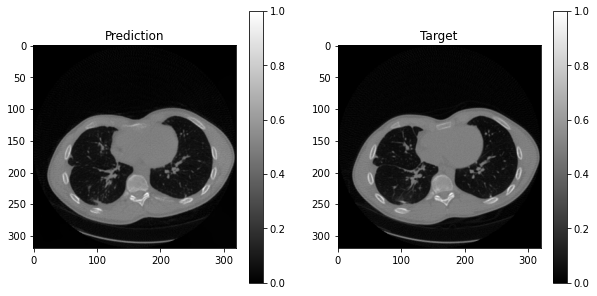

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.array(predictions), cmap='gray')
plt.title('Prediction')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.array(targets), cmap='gray')
plt.title('Target')
plt.colorbar()

Text(0.5, 1.0, 'targ')

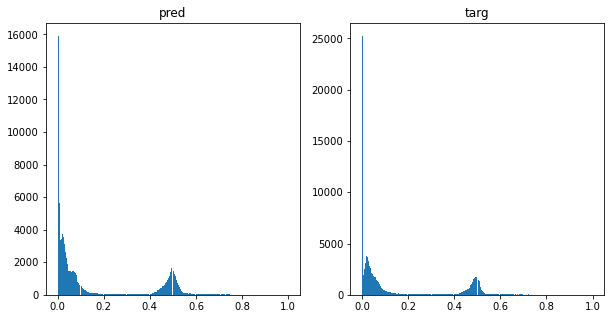

In [15]:
# Normalized Histograms
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(np.array(predictions).ravel(), bins=255)
plt.title('pred')
plt.subplot(122)
plt.hist(np.array(targets).ravel(), bins=255)
plt.title('targ')